## Wave spectrum changes by high-resolution currents

imports

In [1]:
import os
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import stereoid.tropical_cyclones.backscatter as backscatter
from stereoid.tropical_cyclones.wave_spectra import Kudry_spec
from stereoid.tropical_cyclones.wave_spectra import spec_peak
from stereoid.tropical_cyclones.Doppler import DopRIM
from stereoid.tropical_cyclones.high_resolution_var import Kudry2005_currents
from stereoid.tropical_cyclones.high_resolution_var import Kudry2005_divergence1d

spectral grid

In [2]:
# wavelengths and wave numbers
g=9.81
n_k = 100  # number of frequencies single side (total 2*n_k - 1)
lambda_min = 0.01  # minimum wave length
lambda_max = 1000  # maximum wave length
k_min = 2 * np.pi / lambda_max  # minimum wave number
k_max = 2 * np.pi / lambda_min # should at least pass the Bragg wave number
#k_x = k_min * np.arange( 1, n_k + 1 )  # vector of wave numbers (single side)
k_x = np.reshape(10**np.linspace(np.log10(k_min),np.log10(k_max),n_k),(1,n_k))
#k_x[ 20: ] = k_x[ 20: ] * 1.015 ** np.arange( 1, n_k - 20 )  # extend domain (distance increase higher wave noms)
k_x = np.append( np.append( -np.flip( k_x ), 0 ), k_x )  # double sided spectrum
dk=np.gradient(k_x,1)
k_x = np.dot( np.ones( (n_k * 2 + 1, 1) ), k_x.reshape( 1, n_k * 2 + 1 ) )  # two dimensional
k_y = np.transpose( k_x )
k = np.sqrt( k_x ** 2 + k_y ** 2 )
omega=np.where(k > 0, np.sqrt(g*k), 0)
phi = np.arctan2( k_y, k_x )  # 0 is cross-track direction waves, 90 along-track
dks = np.outer( dk, dk )  # patch size

mean spectrum

In [3]:
u_10=10
fetch=500E3
phi_w=0
Bm, B_neq, B_eq, I_swpc = Kudry_spec( k_x, k_y, u_10, fetch, phi_w, dks )
Sm = np.where( k > 0, Bm * k ** -4, 0 )
Nm = np.where( k > 0, omega / k * Bm, 0 )

Input current and gradient

Text(0, 0.5, 'along-track distance [m]')

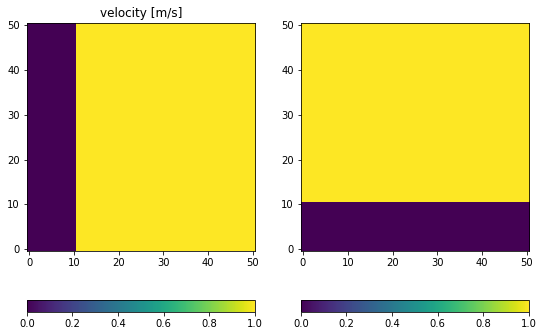

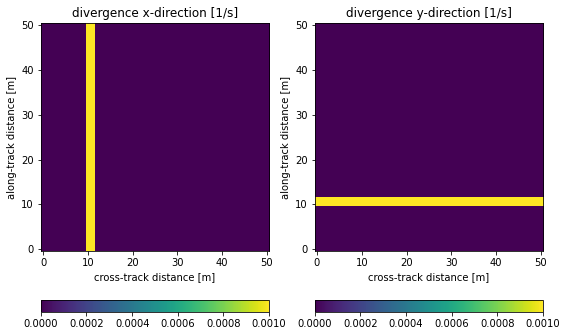

In [4]:
res_x=500
max_x=25000
x=np.arange(0,max_x+res_x,res_x)
res_y=500
max_y=25000
y = np.arange(0,max_y+res_y,res_y)
xm = np.outer(np.ones(len(y)),x)
ym = np.outer(np.ones(len(x)),y)
ym = np.transpose(ym)
u0=0.5
L=2000
p0=5000

# input a simplified velocity field
#u=u0*(1+np.tanh((xm-p0)/L))/2-u0*(1+np.tanh((xm-p0*2)/L))/2+u0*(1+np.tanh((xm-p0*4)/L))/2-u0*(1+np.tanh((xm-p0*5)/L))/2
u=np.zeros(xm.shape); u[xm > p0]=1
v=np.zeros(u.shape); v[ym > p0]=1


# compute gradients
dudy,dudx=np.gradient(u,res_x,res_x)
dvdy,dvdx=np.gradient(v,res_x,res_x)

plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.imshow(u,origin='lower')
plt.title('velocity [m/s]')
plt.colorbar(orientation='horizontal')
plt.subplot(1,2,2)
plt.imshow(v,origin='lower')
plt.colorbar(orientation='horizontal')

plt.figure(figsize=(9,6))
plt.subplot(1,2,1)
plt.imshow(dudx,origin='lower')
plt.title('divergence x-direction [1/s]')
plt.colorbar(orientation='horizontal')
plt.xlabel('cross-track distance [m]')
plt.ylabel('along-track distance [m]')
plt.subplot(1,2,2)
plt.imshow(dvdy,origin='lower')
plt.colorbar(orientation='horizontal')
plt.title('divergence y-direction [1/s]')
plt.xlabel('cross-track distance [m]')
plt.ylabel('along-track distance [m]')

#plt.figure(figsize=(9,6))
#plt.subplot(1,2,1)
#plt.title('shear [1/s]')
#plt.imshow(dvdx)
#plt.colorbar(orientation='horizontal')
#plt.subplot(1,2,2)
#plt.imshow(dvdy)
#plt.colorbar(orientation='horizontal')

Spatially varying wave spectrum and backscatter

In [5]:
Tx_4D,Ty_4D,mk_x,tau=Kudry2005_currents( B_neq, B_eq, I_swpc, k_x, k_y, dudx, dvdy, res_x, u_10, phi_w, fetch, m_star = 1 )
Tx_3D,Ty_3D=Kudry2005_divergence1d( B_neq, B_eq, I_swpc, k_x, k_y, res_x, u_10, phi_w, fetch, m_star = 1 )

In [6]:
shp=k_x.shape
SHP=dudx.shape
dB=np.zeros((shp[0],shp[1],SHP[0],SHP[1]))
for i in range(0,shp[0]):
    print(i)
    for j in range(0,shp[1]):
        #Tx_temp=np.reshape(Tx_4D[i,j,0,:],(1,SHP[1])) # convert it to 'one-dimensional' impulse response
        #Ty_temp=np.reshape(Ty_4D[i,j,:,0],(SHP[0],1))
        Tx_temp=np.reshape(Tx_3D[i,j,0:SHP[1]],(1,SHP[1])) # convert it to 'one-dimensional' impulse response
        Ty_temp=np.reshape(Ty_3D[i,j,0:SHP[0]],(SHP[0],1))
        dTx=sp.signal.convolve2d(dudx,Tx_temp)[:,0:SHP[1]]
        dTy=sp.signal.convolve2d(dvdy,Ty_temp)[0:SHP[1],:]
        T=dTx[:,0:len(x)]+dTy[0:len(y),:]
        if np.min(T) < -1:
            print('Warning! Negative values for curvature spectrum!')
            print(i,j,k_x[i,j],k_y[i,j],np.min(T),mk_x[i,j],tau[i,j])
        dB[i,j,:,:]=Bm[i,j]*T

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
Warning! Negative values for curvature spectrum!
69 141 0.6582363905497904 -0.20574599187830553 -1.000678229760571 -4.357675535975502 17.51232870616052
Warning! Negative values for curvature spectrum!
69 142 0.73941275688529 -0.20574599187830553 -1.0003840069126413 -4.522031457261577 15.735736657359663
70
Warning! Negative values for curvature spectrum!
70 141 0.6582363905497904 -0.18315818573991993 -1.003917000086738 -4.454147270398243 17.676331163825427
Warning! Negative values for curvature spectrum!
70 142 0.73941275688529 -0.18315818573991993 -1.0075922712314551 -4.626599737387444 15.854396330822745
71
Warning! Negative values for curvature spectrum!
71 141 0.6582363905497904 -0.1630501799684211 -1.005360783088854 -4.533565042290708 17.80962442677183
Warning! Negative values for curva

KeyboardInterrupt: 

In [ ]:
lambda_lim=6
k_lim=2*np.pi/lambda_lim
ph=np.linspace(0,2*np.pi,61)
xR=np.cos(ph)*k_lim
yR=np.sin(ph)*k_lim

In [ ]:
sigma_sp=np.zeros(SHP) # specular scattering
sigma_br=np.zeros(SHP) # Bragg scattering
sigma_wb=np.zeros(SHP) # wave breaking
q=np.zeros(SHP) # fraction of surface covered by breakers
for i in range(0,SHP[0]):
    for j in range(0,SHP[1]):
        S=np.where(k > 0,(Bm+dB[:,:,i,j])*k**-4,Sm)
        S[S < 0]=0 # this is an override, which I do not like
        sigma_sp[i,j], sigma_br[i,j], sigma_wb[i,j], q[i,j] = backscatter.backscatter_Kudry2005( S, k_x, k_y, dks, phi_w, u_10=u_10)

plot

In [ ]:
s_sp, s_br, s_wb, q_check = backscatter.backscatter_Kudry2005( Sm, k_x, k_y, dks, phi_w, u_10=u_10)
print(s_sp*(1-q_check),s_br*(1-q_check),s_wb*q_check,q_check)

plt.figure(figsize=(9,12))
plt.subplot(1,4,1)
plt.imshow(sigma_sp*(1-q),origin='lower',extent=(np.min(x),np.max(x),np.min(y),np.max(y)))
plt.colorbar(orientation='horizontal')
plt.title('specular backscatter')
#plt.xlabel('cross-track distance [m]')
plt.ylabel('along-track distance [m]')
plt.subplot(1,4,2)
plt.imshow(sigma_br*(1-q),origin='lower',extent=(np.min(x),np.max(x),np.min(y),np.max(y)))
plt.colorbar(orientation='horizontal')
plt.title('Bragg backscatter')
#plt.xlabel('cross-track distance [m]')
#plt.ylabel('along-track distance [m]')
plt.subplot(1,4,3)
plt.imshow(sigma_wb*q,origin='lower',extent=(np.min(x),np.max(x),np.min(y),np.max(y)))
plt.colorbar(orientation='horizontal')
plt.title('wave breaking backscatter')
plt.xlabel('cross-track distance [m]')
plt.ylabel('along-track distance [m]')
plt.subplot(1,4,4)
plt.imshow(sigma_sp*(1-q)+sigma_br*(1-q)+sigma_wb*q,origin='lower',extent=(np.min(x),np.max(x),np.min(y),np.max(y)))
plt.colorbar(orientation='horizontal')
plt.title('total backscatter')
plt.xlabel('cross-track distance [m]')
#plt.ylabel('along-track distance [m]')

plt.figure(figsize=(9,9))
plt.subplot(2,2,1)
plt.plot(x,sigma_sp[0,:]*(1-q[0,:]))
plt.xlabel('cross-track distance [m]')
plt.title('specular backscatter')
plt.subplot(2,2,2)
plt.plot(x,sigma_br[0,:]*(1-q[0,:]))
plt.xlabel('cross-track distance [m]')
plt.title('Bragg backscatter')
plt.subplot(2,2,3)
plt.plot(x,sigma_wb[0,:]*q[0,:])
plt.xlabel('cross-track distance [m]')
plt.title('wave breaking backscatter')
plt.subplot(2,2,4)
plt.plot(x,sigma_sp[0,:]*(1-q[0,:])+sigma_br[0,:]*(1-q[0,:])+sigma_wb[0,:]*q[0,:])
plt.xlabel('cross-track distance [m]')
plt.title('total backscatter')